In [1]:
import networkx as nx
import pandas as pd
import community
import matplotlib.pyplot as plt
from functools import reduce
import pickle
import numpy as np
import operator
import random
from shutil import copyfile

%matplotlib inline

In [2]:
from bokeh.io import show, output_file
from bokeh.models import Legend,StaticLayoutProvider, LegendItem, Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool, SaveTool, BoxZoomTool, WheelZoomTool, PanTool
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4
from bokeh.plotting import figure
from bokeh.core.properties import field

from bokeh.layouts import widgetbox
from bokeh.models.widgets import Slider

from networkx.drawing.nx_agraph import graphviz_layout

In [3]:
from Bio import SeqIO

In [4]:
q=pd.read_csv('v2_edges_06_after_cleaning_checkcontrol_dereplication.csv')

In [5]:
q.columns=['Source','Target','Distance']

In [6]:
q['Similarity']=(1-q['Distance'])**2

In [7]:
rt=nx.from_pandas_edgelist(q,source='Source',target='Target',edge_attr=['Distance','Similarity'])

In [8]:
grado=list(rt.degree())
nodos=[i[0] for i in grado]
gra=[i[1] for i in grado]
stats=pd.DataFrame({'nodos':nodos,'grado':gra}).sort_values('grado')

In [9]:
stats

,grado,nodos
1817,1,NC_008268.1.cluster003
1551,1,NZ_AODO01000001.cluster011
1791,1,NZ_CAPS01000167.cluster023
1552,1,NZ_CVQP01000001.cluster004
1558,1,NZ_CP021354.1.cluster001
1559,1,NZ_FZOW01000050.cluster016
1785,1,NZ_FNDN01000037.cluster008
1570,1,NZ_QTTW01000001.cluster019
1717,1,NZ_QTTW01000001.cluster003
1781,1,NZ_NHML01000070.cluster011


In [10]:
info=pd.read_csv('v2_nodes_after_cleaning_checkcontrol_dereplication.csv')
infoex=info.copy()
infoex1=infoex[['Id','reduccion']]

In [11]:
infoex1['reduccion'].value_counts()

NRPS             717
Other            337
Terpene          194
PKS              192
RiPPs            129
Ectoine          112
Butyrolactone    108
Other hybrids    102
Name: reduccion, dtype: int64

In [12]:
xg=pd.DataFrame({'Id':[i for i in nx.nodes(rt)]})
xgredu=pd.merge(xg,infoex1,how='left',on='Id')
nx.set_node_attributes(rt, dict(zip(xgredu['Id'],xgredu['reduccion'])),'bgc')

In [13]:
tempo=rt.copy()

In [14]:
g1=tempo.subgraph([x for x,y in tempo.nodes(data=True) if y['bgc']=='NRPS']).copy()

In [15]:
grado=list(g1.degree())
nodos=[i[0] for i in grado]
gra=[i[1] for i in grado]
stats=pd.DataFrame({'nodos':nodos,'grado':gra}).sort_values('grado')
nozero=stats[stats['grado']!=0]['nodos'].tolist()

In [16]:
g2=g1.subgraph(nozero).copy()

In [39]:
len(nx.nodes(g2))

679

In [27]:
tryer=sorted(nx.connected_component_subgraphs(g2),key=len,reverse=True)
q=reduce(lambda x,y:nx.compose(x,y),tryer[1:])

In [28]:
partition = community.best_partition(g2,weight='Similarity',resolution=1,random_state=2019)
partitionbig = community.best_partition(tryer[0],weight='Similarity',resolution=1,random_state=2019)
partitionq = community.best_partition(q,weight='Similarity',resolution=1,random_state=2019)

In [29]:
sizebig = float(len(set(partitionbig.values())))
sizeq = float(len(set(partitionq.values())))
size = float(len(set(partition.values())))
print(sizebig)
print(sizeq)
print(size)

8.0
38.0
44.0


rw=x

In [30]:
ids=[pr for pr in partition.keys()]
gcf=[pq for pq in partition.values()]
tablagcf=pd.DataFrame({'Id':ids,'gcf':gcf})
tablagcf=tablagcf.sort_values('gcf')

In [38]:
tablagcf['gcf'].value_counts().to_excel('v2_gcf_stats.xlsx')

In [32]:
tablagcf.to_csv('v2_gcf_after_cleaning_checkcontrol_dereplication.csv',index=False)

In [17]:
rw=pd.read_csv('v2_gcf_after_cleaning_checkcontrol_dereplication.csv')

In [62]:
#rw=tablagcf.copy()

In [6]:
rw

,Id,gcf
0,NZ_NPGA01000020.cluster001,0
1,NZ_NOZF01000045.cluster004,0
2,NZ_KI519398.1.cluster011,1
3,NZ_QAOZ01000001.cluster001,1
4,NZ_JMFB01000001.cluster017,1
5,NZ_CP015220.1.cluster013,1
6,NZ_CP015235.1.cluster015,1
7,NZ_JMFC01000001.cluster024,1
8,NZ_NPFY01000011.cluster008,1
9,NZ_CP027793.1.cluster008,1


In [18]:
subgcf={}
pix=g2.copy()
for i in pd.unique(rw['gcf']):
    tmp=rw[rw['gcf']==i]['Id'].tolist()
    subt=pix.subgraph(tmp)
    subgcf[i]=subt

In [19]:
nrpst=info[info['reduccion']=='NRPS']
clu=[]
leg=[]
for i in nrpst['Id']:
    #print(i)
    q=SeqIO.read('clusters/'+i+'.gbk','genbank')
    clu.append(i)
    leg.append(len(q))
rt1=pd.DataFrame({'cluster':clu,'length':leg})
largosdict=dict(zip(rt1.cluster,rt1.length))

In [20]:
def retrievebest(dictio):
    nog=[]
    maximo=max(list(dictio.values()))
    for key, value in dictio.items():
        if value==maximo:
            nog.append(key)
    return nog

In [21]:
for key,j in subgcf.items():
    nodal=list(nx.nodes(j))
    bet_cent=nx.betweenness_centrality(j,seed=2020)
    deg_cent=nx.degree_centrality(j)
    nodals=pd.Series(nodal)
    df1=pd.DataFrame({'nodos':nodals,'length':nodals.apply(lambda x:largosdict[x]),'degree':nodals.apply(lambda x:deg_cent[x]),'betweenness':nodals.apply(lambda x:bet_cent[x])})
    df1=df1[['nodos','length','degree','betweenness']]
    df1.to_excel('tablas_gcf_v2/v2_tablas_gcf_'+str(key)+'.xlsx',index=False)

,betweenness,degree,length,nodos
0,0.0,1.0,60874,NZ_NPFL01000006.cluster018
1,0.0,1.0,60874,NZ_JMFC01000001.cluster012


In [63]:
q[q['Target']=='NZ_ACNO01000124.cluster018']

,Source,Target,Distance
8717,NC_012490.1.cluster007,NZ_ACNO01000124.cluster018,0.047421


In [64]:
rare=[]
centrales={}
for key,j in subgcf.items():
    if len(nx.nodes(j))>=2:
        print(key)
        print(len(nx.nodes(j)))
        bet_cent=nx.betweenness_centrality(j,seed=2020)
        bet_node=max(bet_cent.items(), key=operator.itemgetter(1))[0]
        lista_bet=retrievebest(bet_cent)
        #print(lista_bet)
        deg_cent=nx.degree_centrality(j)
        deg_node=max(deg_cent.items(), key=operator.itemgetter(1))[0]
        lista_deg=retrievebest(deg_cent)
        intersection=list(set(lista_bet)&set(list(lista_deg)))
        print(lista_bet)
        print(lista_deg)
        if intersection!=[]:
            #print(intersection)
            cent_node=random.choice(intersection)
            centrales[key]=cent_node
        else:
            rare.append(j)
            print(False)
            cent_node=deg_node
            centrales[key]=cent_node
    else:
        print(key)
        print(len(nx.nodes(j)))
        cent_node=random.choice(list(nx.nodes(j)))
        centrales[key]=cent_node

0
42
['NZ_CEDU01000001.cluster018', 'NZ_BCWX01000001.cluster012', 'NZ_LRRJ01000001.cluster017', 'NZ_LWHK01000128.cluster006', 'NZ_KZ845630.1.cluster020', 'NZ_NOVD01000100.cluster003', 'NZ_QUNE01000001.cluster017']
['NZ_CEDU01000001.cluster018', 'NZ_BCWX01000001.cluster012', 'NZ_LRRJ01000001.cluster017', 'NZ_LWHK01000128.cluster006', 'NZ_KZ845630.1.cluster020', 'NZ_NOVD01000100.cluster003', 'NZ_QUNE01000001.cluster017']
['NZ_KZ845630.1.cluster020', 'NZ_CEDU01000001.cluster018', 'NZ_BCWX01000001.cluster012', 'NZ_NOVD01000100.cluster003', 'NZ_QUNE01000001.cluster017', 'NZ_LRRJ01000001.cluster017', 'NZ_LWHK01000128.cluster006']
1
4
['NZ_BAWF01000137.cluster029', 'NZ_CP003949.1.cluster025', 'NZ_QTTP01000001.cluster018', 'NC_012522.1.cluster011']
['NZ_BAWF01000137.cluster029', 'NZ_CP003949.1.cluster025', 'NZ_QTTP01000001.cluster018', 'NC_012522.1.cluster011']
['NZ_BAWF01000137.cluster029', 'NZ_CP003949.1.cluster025', 'NZ_QTTP01000001.cluster018', 'NC_012522.1.cluster011']
2
141
['NZ_BAWF0100

['NZ_QAOW01000001.cluster008', 'NZ_UGVJ01000003.cluster014']
['NZ_QAOW01000001.cluster008', 'NZ_UGVJ01000003.cluster014']
['NZ_QAOW01000001.cluster008', 'NZ_UGVJ01000003.cluster014']
29
13
['NZ_NHML01000070.cluster012']
['NZ_NHML01000070.cluster012']
['NZ_NHML01000070.cluster012']
30
3
['NZ_FOAW01000059.cluster008', 'NZ_JMLO01000001.cluster012', 'NZ_QAOZ01000001.cluster016']
['NZ_FOAW01000059.cluster008', 'NZ_JMLO01000001.cluster012', 'NZ_QAOZ01000001.cluster016']
['NZ_FOAW01000059.cluster008', 'NZ_JMLO01000001.cluster012', 'NZ_QAOZ01000001.cluster016']
31
2
['NZ_NPFW01000022.cluster016', 'NZ_FZOW01000050.cluster018']
['NZ_NPFW01000022.cluster016', 'NZ_FZOW01000050.cluster018']
['NZ_NPFW01000022.cluster016', 'NZ_FZOW01000050.cluster018']
32
4
['NZ_QTTP01000001.cluster025', 'NZ_UAUI01000027.cluster026']
['NZ_QTTP01000001.cluster025', 'NZ_UAUI01000027.cluster026']
['NZ_QTTP01000001.cluster025', 'NZ_UAUI01000027.cluster026']
33
5
['NZ_QUNE01000001.cluster014', 'NZ_CM003191.1.cluster003', 

In [66]:
clusterx=rare[2].copy()

In [67]:
clusteri=[]
leng=[]
for i in list(nx.nodes(clusterx)):
    q=SeqIO.read('clusters/'+i+'.gbk','genbank')
    clusteri.append(i)
    leng.append(len(q))

In [68]:
bae=pd.DataFrame({'cluster':clusteri,'length':leng})

In [69]:
for i in bae['cluster']:
    copyfile('clusters/'+i+'.gbk','5_clusters/'+i+'.gbk')

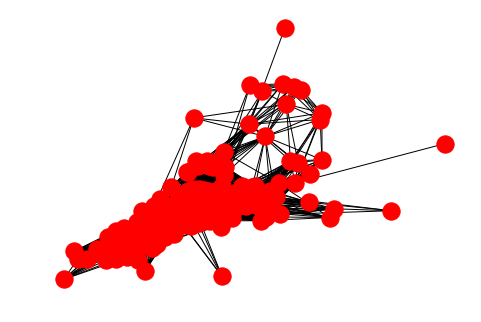

In [17]:
nx.draw(clusterx)

In [34]:
tir=pd.DataFrame({'cluster':list(nx.degree_centrality(clusterx).keys()),'cent':list(nx.degree_centrality(clusterx).values())})

In [41]:
tir2=tir.sort_values('cent',ascending=False)

In [42]:
tir2.merge(bae,how='left',on='cluster')

,cent,cluster,length
0,0.649215,NZ_MRCL01000001.cluster022,8840
1,0.623037,NZ_LYXB01000006.cluster001,7167
2,0.617801,NZ_JMEW01000001.cluster005,8272
3,0.602094,NZ_BAWF01000137.cluster010,9721
4,0.596859,NZ_MKKY01000003.cluster019,10392
5,0.596859,NZ_NOVD01000100.cluster001,6592
6,0.591623,NZ_MJVD01000006.cluster004,9002
7,0.591623,NZ_LDPN01000012.cluster013,9410
8,0.586387,NZ_MJVD01000006.cluster023,8626
9,0.586387,NZ_JTIZ01000001.cluster004,10438


In [144]:
raros=reduce(lambda x,y:nx.compose(x.copy(),y.copy()),rare)
nx.set_node_attributes(raros, dict(zip(list(nx.nodes(raros)),list(nx.nodes(raros)))),'Id')

In [145]:
plot = Plot(plot_width=1000, plot_height=1000,
            x_range=Range1d(0,2000), y_range=Range1d(0,2000))
plot.title.text = "Graph Interaction Demonstration"

plot.add_tools(HoverTool(tooltips=[('id','@Id')]), TapTool(), BoxSelectTool(),SaveTool(),WheelZoomTool(), PanTool())


graph_renderer = from_networkx(raros,graphviz_layout,prog='neato')#scale=1,center=(0,0),k=0.1)

graph_renderer.node_renderer.glyph = Circle(size=10, fill_color='red')
graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
#graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = NodesAndLinkedEdges()
#graph_renderer.layout_provider=StaticLayoutProvider(graph_layout=graphviz_layout(g1,prog='neato'))

plot.renderers.append(graph_renderer)

output_file("interactive_graphs.html")

show(plot)

In [146]:
hy=pd.DataFrame({'gcf':list(centrales.keys()),'center':list(centrales.values())})

In [148]:
hy=hy[['gcf','center']]

In [150]:
hy.to_csv('gcf_nodes.xlsx',index=False)
hy.to_excel('gcf_nodes.xlsx',index=False)

In [152]:
for i in hy['center']:
    copyfile('clusters/'+i+'.gbk','nodos_centrales/'+i+'.gbk')

In [51]:
pd.Series(list(centrales.values())).to_csv('nodos_centrales.csv',index=False)

In [15]:
nuevo=reduce(lambda x,y:nx.compose(x.copy(),y.copy()),subgcf)

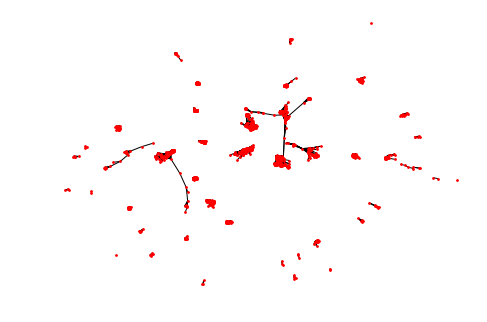

In [17]:
nx.draw(nuevo,node_size=3)

from networkx.algorithms.community import girvan_newman
from networkx import edge_betweenness_centrality as betweenness
def most_central_edge(G):
    centrality = betweenness(G, weight='Distance')
    return max(centrality, key=centrality.get)


comp = girvan_newman(g1, most_valuable_edge=most_central_edge)
#tuple(sorted(c) for c in next(comp))

In [133]:
tryer=sorted(nx.connected_component_subgraphs(g1),key=len,reverse=True)
q=reduce(lambda x,y:nx.compose(x,y),tryer[1:])

In [136]:
partition = community.best_partition(g1,weight='Distance',resolution=1,random_state=2019)
partitionbig = community.best_partition(tryer[0],weight='Distance',resolution=1,random_state=2019)
partitionq = community.best_partition(q,weight='Distance',resolution=1,random_state=2019)

In [137]:
sizebig = float(len(set(partitionbig.values())))
sizeq = float(len(set(partitionq.values())))
size = float(len(set(partition.values())))
print(sizebig)
print(sizeq)
print(size)

14.0
32.0
46.0


In [123]:
x=pd.DataFrame({'Id':list(partition.keys()),'gcf':list(partition.values())})
x=x[['Id','gcf']]

In [101]:
x

,Id,gcf
0,NZ_CP024315.1.cluster009,0
1,NZ_NSDY01000001.cluster004,1
2,NZ_LDPN01000012.cluster008,2
3,NZ_JMEM01000001.cluster024,3
4,NZ_NOZA01000030.cluster001,3
5,NZ_NPGA01000020.cluster007,4
6,NZ_NOZJ01000008.cluster017,0
7,NZ_NPFU01000018.cluster001,5
8,NZ_NPFR01000029.cluster004,6
9,NZ_NPFX01000014.cluster008,6


In [152]:
with open('rhodo_contig_genome_dict.pkl','rb') as f2: 
	dict2=pickle.load(f2)
with open('rhodo_assembly_name.pkl','rb') as f3: 
	dict3=pickle.load(f3)
with open('clado_dict.pkl','rb') as f4: 
	dict4=pickle.load(f4)

In [150]:
x['bacteria']=x['Id'].apply(lambda x:dict3[dict2[(x.split('.')[0]+'.1')]])

In [153]:
x['clado']=x['Id'].apply(lambda x:dict4[dict2[(x.split('.')[0]+'.1')]])

In [6]:
rw2=rw[['Id','gcf']]

In [7]:
rw2.to_csv('gcf_dictionary.csv',index=False)

In [156]:
x.to_excel('gcf_dictionary.xlsx',index=False)

In [9]:
exp=rw[['gcf','clado']]

In [41]:
exp=exp.sort_values('gcf')

In [46]:
exp[exp['gcf']==0]['clado'].value_counts()

3    42
Name: clado, dtype: int64

In [49]:
pre1=len(pd.unique(exp['gcf']))
pre2=len(pd.unique(exp['clado']))
er=np.zeros((pre1,pre2))
cou=0
for i in pd.unique(exp['gcf']):
    exp2=exp[exp['gcf']==i]
    exp3=exp2['clado'].value_counts()
    print(exp3)
    for index in exp3.index:
        er[cou,index]=exp3.loc[index]/exp3.sum()
    cou=cou+1

3    42
Name: clado, dtype: int64
2    4
Name: clado, dtype: int64
3    43
6    32
1    24
7    18
2    18
4     5
0     1
Name: clado, dtype: int64
2    25
5    21
3    10
4     5
Name: clado, dtype: int64
1    25
6    24
7    22
5     8
4     4
2     3
0     2
3     1
Name: clado, dtype: int64
3    87
6    35
2    26
1    19
5    15
7    10
Name: clado, dtype: int64
6    19
1    11
Name: clado, dtype: int64
1    19
7    16
2     2
0     1
Name: clado, dtype: int64
6    14
2    11
5     6
4     1
Name: clado, dtype: int64
3    105
5      8
4      5
Name: clado, dtype: int64
3    45
2    31
6    27
1    26
5    25
7    17
4     5
0     1
Name: clado, dtype: int64
1    20
7    11
0     1
Name: clado, dtype: int64
2    12
Name: clado, dtype: int64
5    11
3     5
2     3
Name: clado, dtype: int64
2    7
Name: clado, dtype: int64
1    10
6     4
3     3
7     2
2     1
0     1
Name: clado, dtype: int64
1    16
6    13
7    12
0     1
Name: clado, dtype: int64
7    17
6    17
1    16
0    

In [75]:
# Package to perform PCA
import sklearn.datasets
import sklearn.decomposition

sklearn_pca = sklearn.decomposition.PCA(n_components=2)
sklearn_pca.fit(er)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [76]:
print('Variance percent explained\n', sklearn_pca.explained_variance_ratio_)

Variance percent explained
 [0.43611378 0.27686051]


In [77]:
tr=sklearn_pca.transform(er)
df_2D = pd.DataFrame(tr,columns=['PCA1', 'PCA2'])

In [70]:
df_2D['gcf']=list(range(45))

Text(0,0.5,'PCA 2')

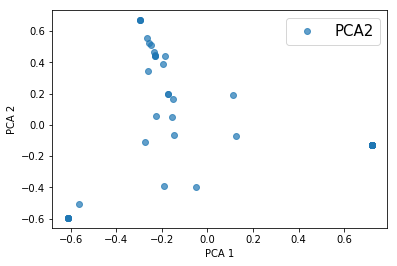

In [78]:
#for key, group in df_2D.groupby(['clado']):
plt.plot(df_2D.PCA1,df_2D.PCA2, 'o', alpha=0.7)

# Tidy up plot
plt.legend(loc=0, fontsize=15)
plt.margins(0.05)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

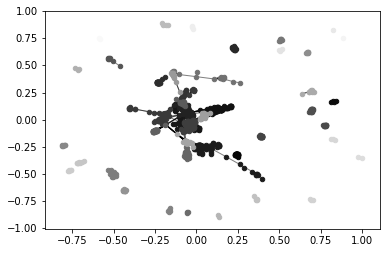

In [129]:
pos = nx.spring_layout(gd)
count = 0.
for com in set(partition.values()) :
    count += 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(gd, pos, list_nodes, node_size = 20,node_color = str(count / size))
nx.draw_networkx_edges(gd, pos, alpha=0.5)
plt.show()

In [22]:
s=community.generate_dendrogram(rt,comp,weight='Distance')

In [49]:
ind = community.induced_graph(partition, g1)

In [62]:
tmpg=nx.connected_component_subgraphs(ind)

In [63]:
connected=[]
for i in tmpg:
    if len(i.nodes())!=1:
        connected.append(i.copy())

In [64]:
nuevo=reduce(lambda x,y:nx.compose(x,y),connected)

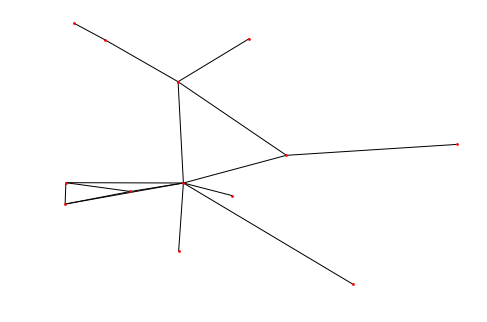

In [66]:
nx.draw(nuevo,node_size=3,pos=nx.spring_layout(nuevo))

In [13]:
def heaviest(G):
    u, v, w = max(G.edges(data='weight'), key=itemgetter(2))
    return (u, v)
comp = girvan_newman(rt, most_valuable_edge=heaviest)

In [68]:
G=nx.erdos_renyi_graph(100, 0.01)
dendrogram = community.generate_dendrogram(G)
for level in range(len(dendrogram) - 1) :
    print("partition at level", level, "is", community.partition_at_level(dendrogram, level))  # NOQA

partition at level 0 is {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 13, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 22, 26: 10, 27: 3, 28: 24, 29: 5, 30: 25, 31: 0, 32: 26, 33: 24, 34: 27, 35: 28, 36: 29, 37: 6, 38: 8, 39: 12, 40: 30, 41: 31, 42: 31, 43: 0, 44: 32, 45: 7, 46: 33, 47: 34, 48: 35, 49: 36, 50: 37, 51: 38, 52: 39, 53: 2, 54: 40, 55: 41, 56: 33, 57: 42, 58: 43, 59: 2, 60: 44, 61: 45, 62: 6, 63: 46, 64: 47, 65: 48, 66: 49, 67: 33, 68: 17, 69: 50, 70: 37, 71: 10, 72: 51, 73: 52, 74: 53, 75: 54, 76: 45, 77: 37, 78: 55, 79: 54, 80: 56, 81: 8, 82: 57, 83: 56, 84: 58, 85: 20, 86: 59, 87: 32, 88: 59, 89: 48, 90: 60, 91: 61, 92: 62, 93: 25, 94: 63, 95: 64, 96: 18, 97: 65, 98: 66, 99: 67}


In [75]:
dendrogram = community.generate_dendrogram(g1,weight='Distance')
for level in range(1,len(dendrogram) - 1) :
    print(level)
    print("partition at level", level, "is", community.partition_at_level(dendrogram, level))  # NOQA

In [76]:
len(dendrogram)

2